In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
from global_config import (
    TRAIN_LABEL_PATH,
    TRAIN_TARGET,
    DICT_LABELS,
    TRAIN_IMAGE_DIR,
    MAX_SAMPLES,
    COLORS_CHANNEL,
    DEVICE,
)

In [4]:
df = pd.read_csv(TRAIN_LABEL_PATH)
df

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
...,...,...
31067,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,21
31068,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,5
31069,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,7
31070,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,25 2 21


In [7]:
empty_labels = df[
    (
        df[TRAIN_TARGET].isnull()
    )
]
print(f"Кількість рядків з порожніми (NaN) мітками: {len(empty_labels)}")

Кількість рядків з порожніми (NaN) мітками: 0


In [16]:
def plot_label_distribution(df, target_col, title="Label Distribution"):
    all_labels = []
    for label_str in df[target_col]:
        labels = label_str.split()
        all_labels.extend(labels)
    label_counts = Counter(all_labels)
    labels = list(label_counts.keys())
    counts = list(label_counts.values())
    plt.figure(figsize=(14, 6))
    sns.barplot(x=counts, y=labels, palette='viridis')
    plt.xlabel("Counts")
    plt.ylabel("Labels")
    plt.title(title)
    for i, v in enumerate(counts):
        plt.text(v + 1, i, str(v), va='center')

    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


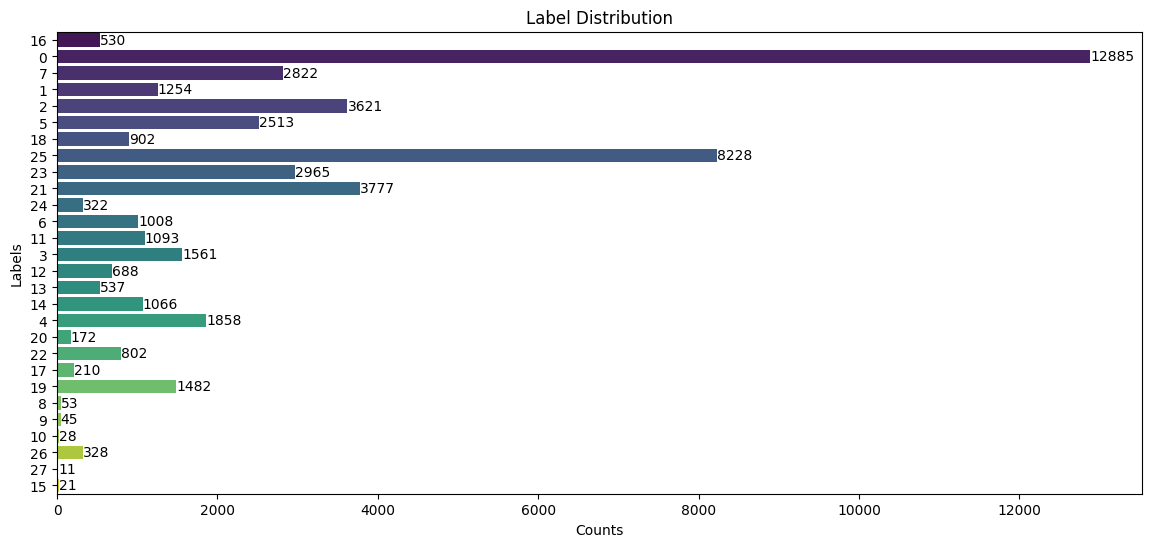

In [17]:
plot_label_distribution(df, 'Target')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


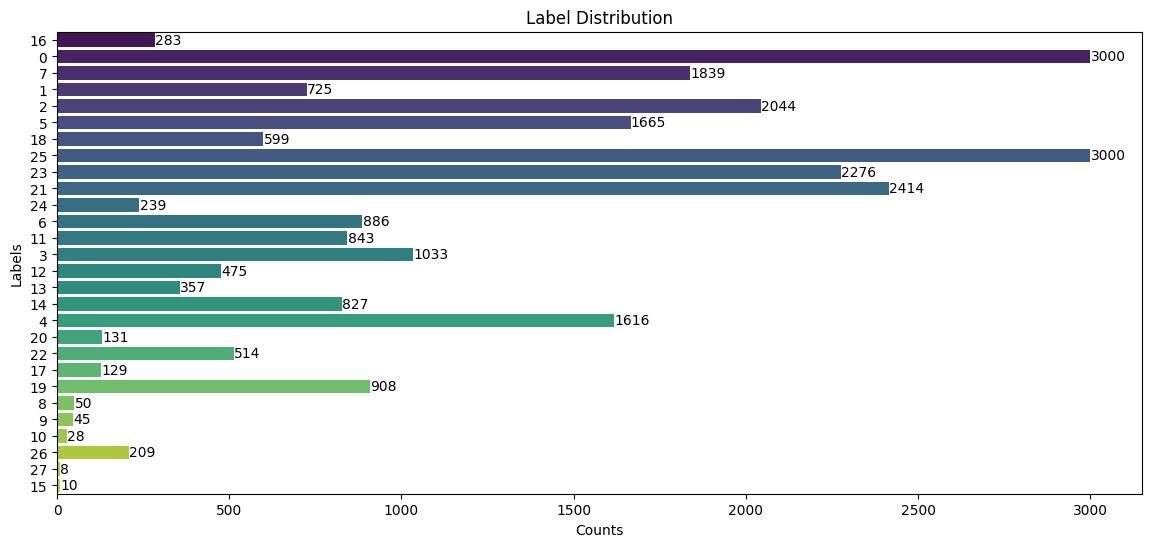

In [18]:
df["labels_list"] = df["Target"].str.split().apply(lambda x: list(map(int, x)))
label_counts = {}
selected_idx = []
for idx, labels in df["labels_list"].items():
    if all(label_counts.get(l, 0) < MAX_SAMPLES for l in labels):
        selected_idx.append(idx)
        for l in labels:
            label_counts[l] = label_counts.get(l, 0) + 1
limited_df = df.loc[selected_idx].drop(columns=["labels_list"])
plot_label_distribution(limited_df, "Target")

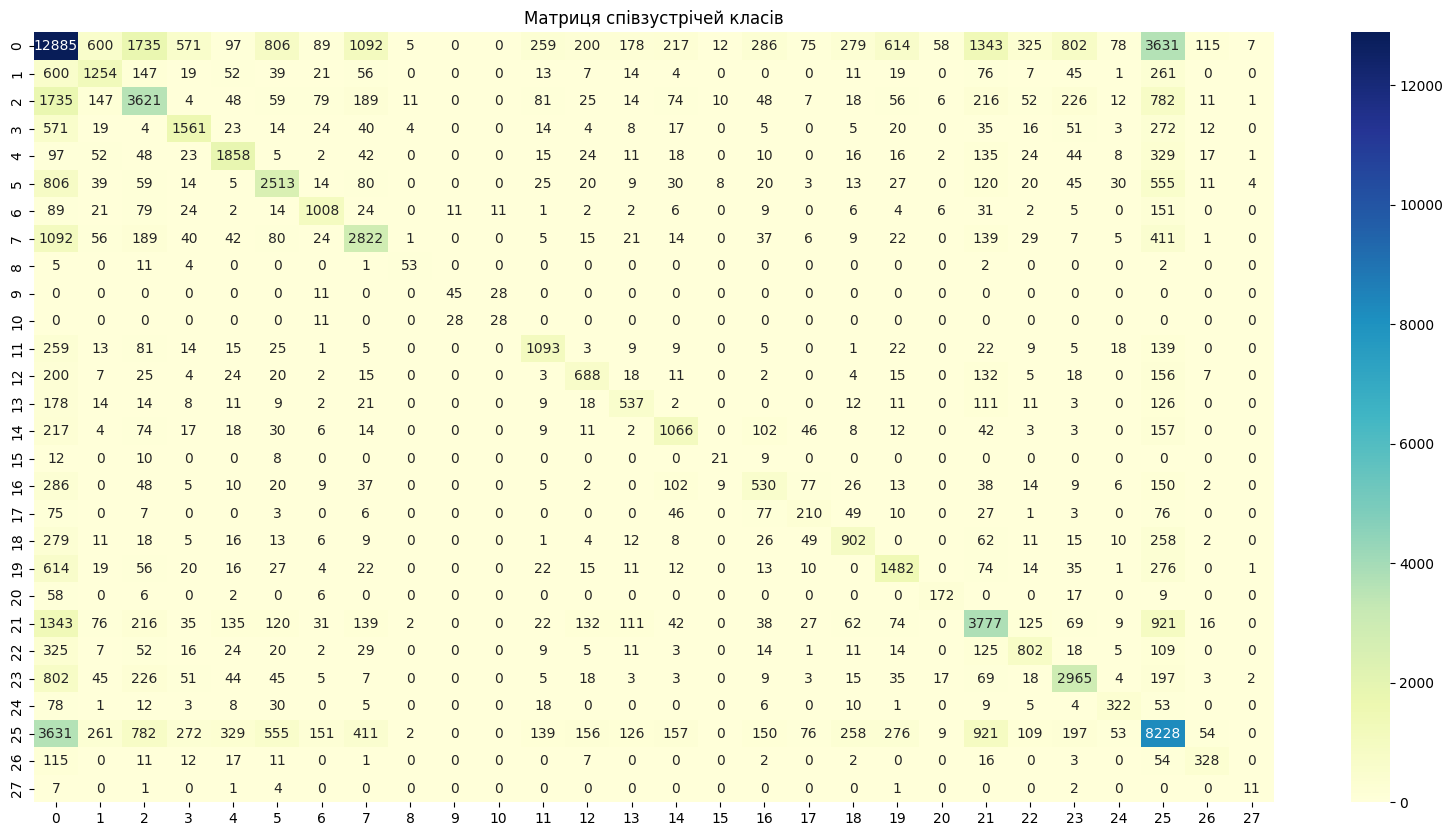

In [42]:
labels_list = df['labels_list']

classes = sorted({l for labels in labels_list for l in labels})
num_classes = len(classes)

co_df = pd.DataFrame(0, index=classes, columns=classes)

for labels in labels_list:
    for i, j in combinations(labels, 2):
        co_df.loc[i, j] += 1
        co_df.loc[j, i] += 1
    for i in labels:
        co_df.loc[i, i] += 1
plt.figure(figsize=(20, 10))
sns.heatmap(co_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Матриця співзустрічей класів")
plt.show()

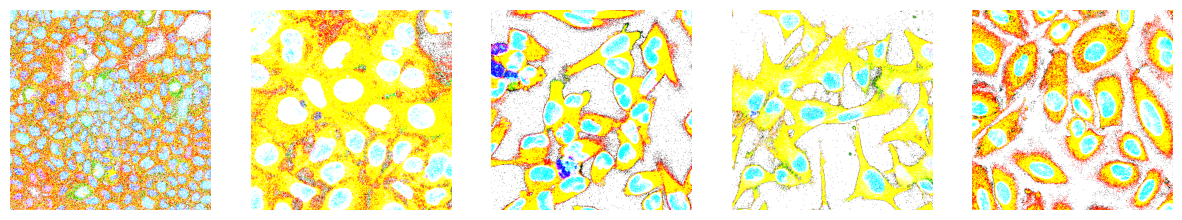

In [6]:
from dataset.protein_dataset import ProteinDataset
dataset_without_aug = ProteinDataset(df, TRAIN_IMAGE_DIR, TRAIN_TARGET)

period = 5
num_images = 5

fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i, idx in enumerate(range(0, len(dataset_without_aug), period)):
    if i >= num_images:
        break
    img, _ = dataset_without_aug[idx]
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].axis("off")

plt.show()

In [8]:
from torch.utils.data import DataLoader
from tqdm import tqdm


dataset = ProteinDataset(df, TRAIN_IMAGE_DIR, TRAIN_TARGET)
loader = DataLoader(dataset, batch_size=128, num_workers=1, pin_memory=True)

mean = torch.zeros(len(COLORS_CHANNEL), device=DEVICE)
std = torch.zeros(len(COLORS_CHANNEL), device=DEVICE)
total_images = 0

for images, _ in tqdm(loader, desc="Обробка зображень"):
    images = images.to(DEVICE)
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)

    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

for i, color in enumerate(COLORS_CHANNEL):
    print(f"{color}: mean={mean[i]:.4f}, std={std[i]:.4f}")


Обробка зображень: 100%|██████████| 243/243 [24:52<00:00,  6.14s/it]

red: mean=20.5127, std=33.1519
green: mean=13.4206, std=22.4314
blue: mean=13.9605, std=35.3512
yellow: mean=21.0908, std=32.4310


In [13]:
mean = [m/255 for m in [20.5127, 13.4206, 13.9605, 21.0908]]
std = [s/255 for s in [33.1519, 22.4314, 35.3512, 32.4310]]
mean, std

([0.08044196078431372,
  0.05262980392156863,
  0.05474705882352941,
  0.08270901960784315],
 [0.13000745098039215,
  0.08796627450980392,
  0.1386321568627451,
  0.12718039215686275])

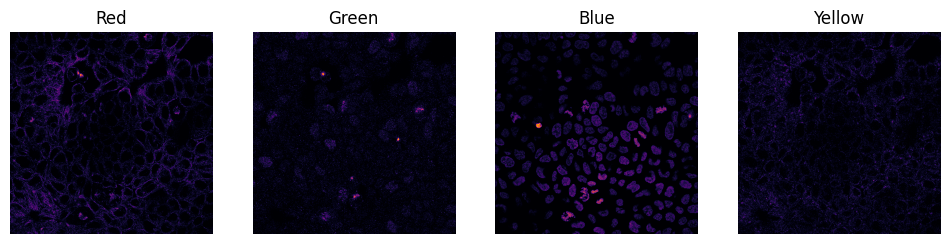

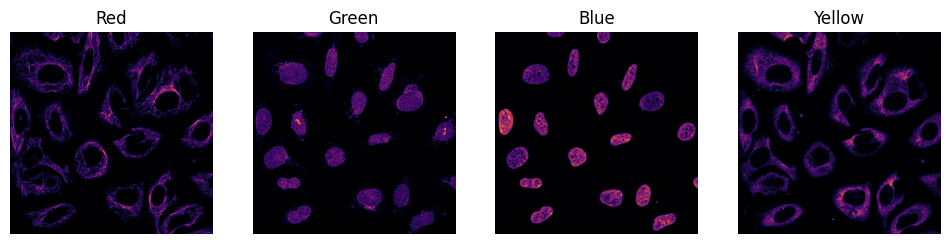

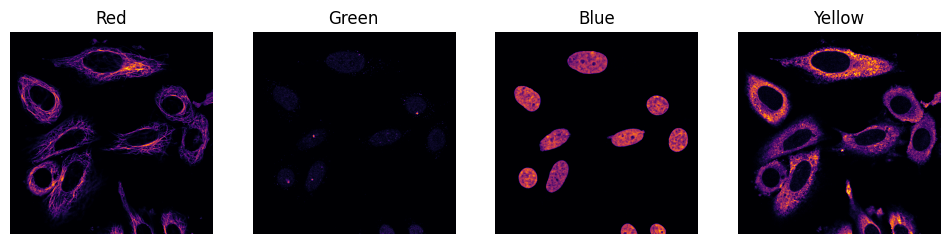

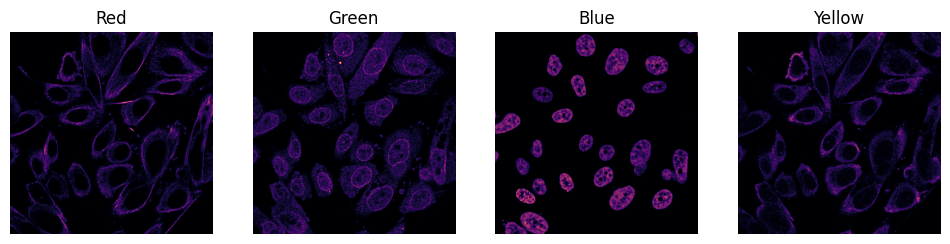

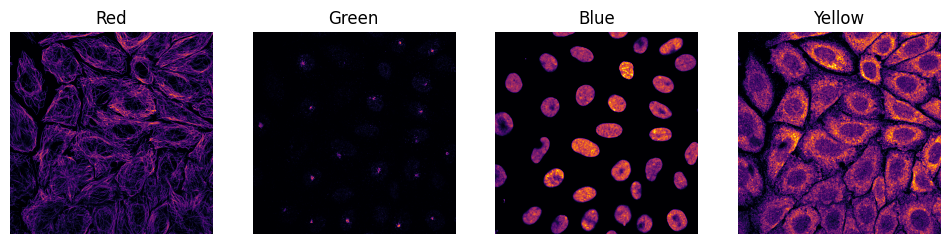

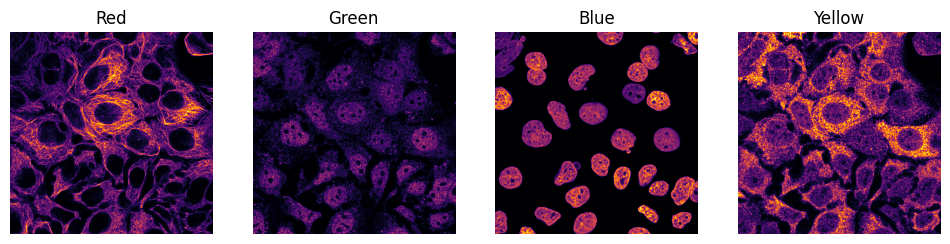

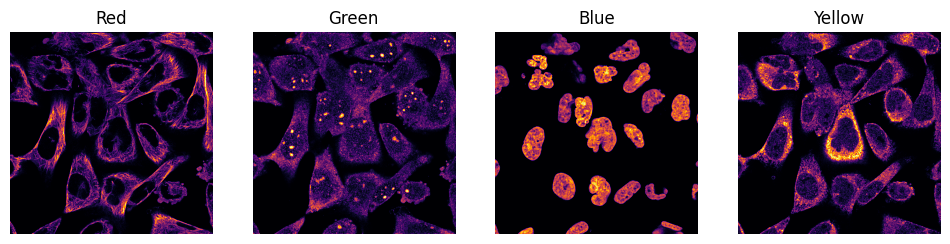

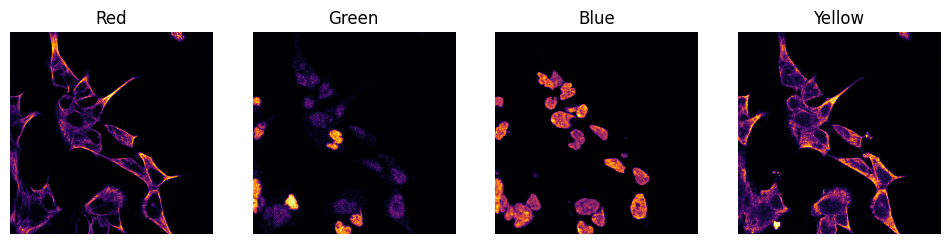

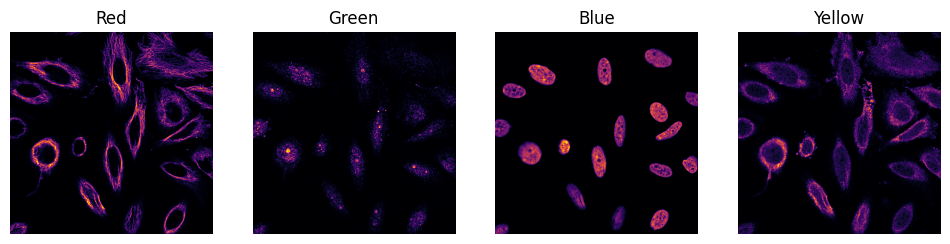

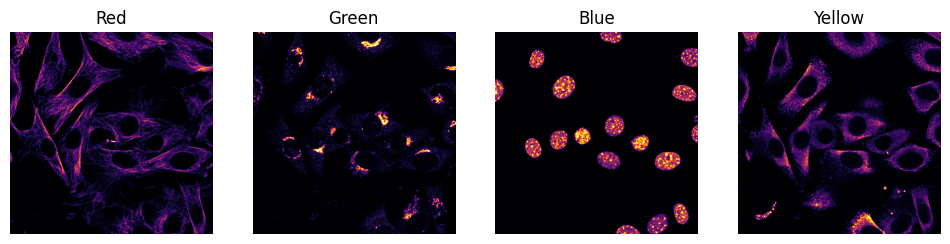

In [12]:

dataset = ProteinDataset(df, TRAIN_IMAGE_DIR, TRAIN_TARGET)

def show_heatmaps(img_tensor, titles=("Red", "Green", "Blue", "Yellow")):
    img_np = img_tensor.numpy()
    fig, axes = plt.subplots(1, img_np.shape[0], figsize=(12, 3))
    for i in range(img_np.shape[0]):
        channel = img_np[i]
        channel_norm = (channel - channel.min()) / (channel.max() - channel.min() + 1e-8)
        axes[i].imshow(channel_norm, cmap="inferno")
        axes[i].set_title(titles[i])
        axes[i].axis("off")
    plt.show()


for idx in range(0, 10):
    img, _ = dataset[idx]
    show_heatmaps(img, titles=["Red", "Green", "Blue", "Yellow"])